In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from artifact import Saw
from detector import WindowTransformerDetector

from data import RealisticArtifactDataset, CachedArtifactDataset, TestArtifactDataset

/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)

In [4]:
test_width = 1024

london_test = Path("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/validation512.london.pkl")

In [5]:
def load_series(names: list[str], split: str):
    series = list()
    counts = list()
    for name in names:
        with open(f"../data/processed/{name}_{split}.pickle", "rb") as f:
            raw = [a for a in pickle.load(f) if len(a) > test_width]
            series.extend(np.array(a).astype(np.float32) for a in raw)
            counts.extend(repeat(1 / len(raw), len(raw)))
    counts = np.array(counts)
    return series, counts / counts.sum()

In [6]:
val = CachedArtifactDataset(file=london_test)

In [7]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [8]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

first_detector = WindowTransformerDetector.load_from_checkpoint("../models/model.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_full_train", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_detector = WindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=50000.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_noLondon", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_nolondon_detector = WindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=17000.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_justLondon", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
transformer_justlondon_detector = WindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/epoch=0-step=30000.ckpt").cpu()

data_asset = ml_client.data.get("output_Train_GPU_full_simple_train", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset.path, destination="./checkpoints_conv/", datastore_operation=ml_client.datastores)
convolution_detector = WindowTransformerDetector.load_from_checkpoint("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_conv/Checkpoint-model_name=0-validation=0.03.ckpt").cpu()


/opt/miniconda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.0.8, which is newer than your current Lightning version: v2.0.0
  rank_zero_warn(


In [9]:
def baseline_detector(input: torch.Tensor) -> torch.Tensor:
    input.squeeze(0)

    prediction = torch.zeros(input.shape)
    # flag points with very high increment as artifact
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[1:] - input[:-1]).abs()
    mean_increment = torch.mean(increments)
    std_increment = torch.std(increments)
    mask = increments > mean_increment + 3*std_increment
    shaped_mask = torch.cat((mask, torch.Tensor([False]))).type(torch.bool)
    prediction[shaped_mask] = 1
    
    # flag highest/lowest point as artifact
    # or better also with mean/std?
    absolute_values = input.abs()
    max_index = torch.argmax(absolute_values)
    prediction[max_index-5 : max_index+5] = 1


    return prediction

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

metrics = pd.DataFrame(columns=['detector', 'accuracy', 'precision', 'recall', 'mse'])
index = 0

preds_base = list()
preds_cnn = list()
preds_trans = list()
gt = list()

threshold = 0.5

for sample in val:
    example = sample["data"]
    stride  = 64
    window  = convolution_detector.window
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example + sample["artifact"])

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_conv = torch.zeros(((length - window) // stride + 1, length))
    predictions_trans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction
        predictions_baseline[i, j : j + window] = transformer_justlondon_detector(s.unsqueeze(0))
        predictions_conv[i, j : j + window] = transformer_nolondon_detector(s.unsqueeze(0))
        predictions_trans[i, j : j + window] = transformer_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    predictions_baseline = predictions_baseline.sum(axis=0) / masks
    preds_base = preds_base + predictions_baseline.tolist()
    predictions_baseline = np.where(predictions_baseline.numpy() > threshold, 1, 0)
    predictions_conv = predictions_conv.sum(axis=0) / masks
    preds_cnn = preds_cnn + predictions_conv.tolist()
    predictions_conv = np.where(predictions_conv.numpy() > threshold, 1, 0)
    predictions_trans = predictions_trans.sum(axis=0) / masks
    preds_trans = preds_trans + predictions_trans.tolist()
    predictions_trans = np.where(predictions_trans.numpy() > threshold, 1, 0)
    gt = gt + sample["mask"].tolist()

    tn_base, fp_base, fn_base, tp_base = confusion_matrix(sample["mask"], predictions_baseline, labels=[0, 1]).ravel()
    tn_conv, fp_conv, fn_conv, tp_conv = confusion_matrix(sample["mask"], predictions_conv, labels=[0, 1]).ravel()
    tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(sample["mask"], predictions_trans, labels=[0, 1]).ravel()

    new_row_baseline = pd.DataFrame([{
        'index': index,
        'detector': 'transformer_justLondon',
        'accuracy': accuracy_score(sample["mask"], predictions_baseline),
        'precision': precision_score(sample["mask"], predictions_baseline),
        'recall': recall_score(sample["mask"], predictions_baseline),
        'mse': mean_squared_error(sample["mask"], predictions_baseline), 
        'tn': tn_base,
        'fp': fp_base, 
        'fn': fn_base, 
        'tp': tp_base
    }])

    new_row_conv = pd.DataFrame([{
        'index': index,
        'detector': 'transformer_noLondon',
        'accuracy': accuracy_score(sample["mask"], predictions_conv),
        'precision': precision_score(sample["mask"], predictions_conv),
        'recall': recall_score(sample["mask"], predictions_conv),
        'mse': mean_squared_error(sample["mask"], predictions_conv),
        'tn': tn_conv,
        'fp': fp_conv, 
        'fn': fn_conv, 
        'tp': tp_conv
    }])

    new_row_trans = pd.DataFrame([{
        'index': index,
        'detector': 'transformer',
        'accuracy': accuracy_score(sample["mask"], predictions_trans),
        'precision': precision_score(sample["mask"], predictions_trans),
        'recall': recall_score(sample["mask"], predictions_trans),
        'mse': mean_squared_error(sample["mask"], predictions_trans),
        'tn': tn_trans,
        'fp': fp_trans, 
        'fn': fn_trans, 
        'tp': tp_trans
    }])

    metrics = pd.concat([metrics, new_row_baseline, new_row_conv, new_row_trans], ignore_index=True)
    index = index+1


/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is i

In [11]:
metrics_total = metrics.groupby('detector')[['accuracy', 'precision', 'recall', 'mse']].mean()
conf_mat_values = metrics.groupby('detector')[['tn', 'fp', 'fn', 'tp']].sum()

In [12]:
metrics_total

,accuracy,precision,recall,mse
detector,,,,
transformer,0.983135,0.681954,0.637972,0.016865
transformer_justLondon,0.985156,0.709085,0.680445,0.014844
transformer_noLondon,0.973929,0.551437,0.497292,0.026071


In [13]:
conf_mat_values = conf_mat_values.convert_dtypes()
conf_mat_values

,tn,fp,fn,tp
detector,,,,
transformer,983136,3241,14443,47756
transformer_justLondon,983113,3264,12301,49898
transformer_noLondon,981911,4466,22871,39328


In [14]:
samples = 983134 + 3243 + 14493 + 47706
39363/samples

0.03753948211669922

In [15]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(gt, preds_base)
J = precision + recall
ix = np.argmax(J)
best_thresh_base = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_cnn)
J = precision + recall
ix = np.argmax(J)
best_thresh_cnn = thresholds[ix]

precision, recall, thresholds = precision_recall_curve(gt, preds_trans)
J = precision + recall
ix = np.argmax(J)
best_thresh_trans = thresholds[ix]

In [21]:
predictions_baseline = np.where(preds_base > best_thresh_base, 1, 0)
predictions_conv = np.where(preds_cnn > best_thresh_cnn, 1, 0)
predictions_trans = np.where(preds_trans > best_thresh_trans, 1, 0)

tn_base, fp_base, fn_base, tp_base = confusion_matrix(gt, predictions_baseline, labels=[0, 1]).ravel()
tn_conv, fp_conv, fn_conv, tp_conv = confusion_matrix(gt, predictions_conv, labels=[0, 1]).ravel()
tn_trans, fp_trans, fn_trans, tp_trans = confusion_matrix(gt, predictions_trans, labels=[0, 1]).ravel()

metrics = pd.DataFrame([{
    'detector': 'transformer_justLondon',
    'threshold': best_thresh_base,
    'accuracy': accuracy_score(gt, predictions_baseline),
    'precision': precision_score(gt, predictions_baseline),
    'recall': recall_score(gt, predictions_baseline),
    'mse': mean_squared_error(gt, predictions_baseline), 
    'tn': tn_base,
    'fp': fp_base, 
    'fn': fn_base, 
    'tp': tp_base
}, 
{
    'detector': 'transformer_noLondon',
    'threshold': best_thresh_cnn,
    'accuracy': accuracy_score(gt, predictions_conv),
    'precision': precision_score(gt, predictions_conv),
    'recall': recall_score(gt, predictions_conv),
    'mse': mean_squared_error(gt, predictions_conv), 
    'tn': tn_conv,
    'fp': fp_conv, 
    'fn': fn_conv, 
    'tp': tp_conv
}, 
{
    'detector': 'transformer',
    'threshold': best_thresh_trans,
    'accuracy': accuracy_score(gt, predictions_trans),
    'precision': precision_score(gt, predictions_trans),
    'recall': recall_score(gt, predictions_trans),
    'mse': mean_squared_error(gt, predictions_trans), 
    'tn': tn_trans,
    'fp': fp_trans, 
    'fn': fn_trans, 
    'tp': tp_trans
}]
)

In [22]:
metrics

,detector,threshold,accuracy,precision,recall,mse,tn,fp,fn,tp
0,transformer_justLondon,0.488190,0.985164,0.935923,0.804997,0.014836,982949,3428,12129,50070
1,transformer_noLondon,0.542881,0.973900,0.913111,0.618885,0.026100,982714,3663,23705,38494
2,transformer,0.506324,0.983147,0.938042,0.766508,0.016853,983228,3149,14523,47676


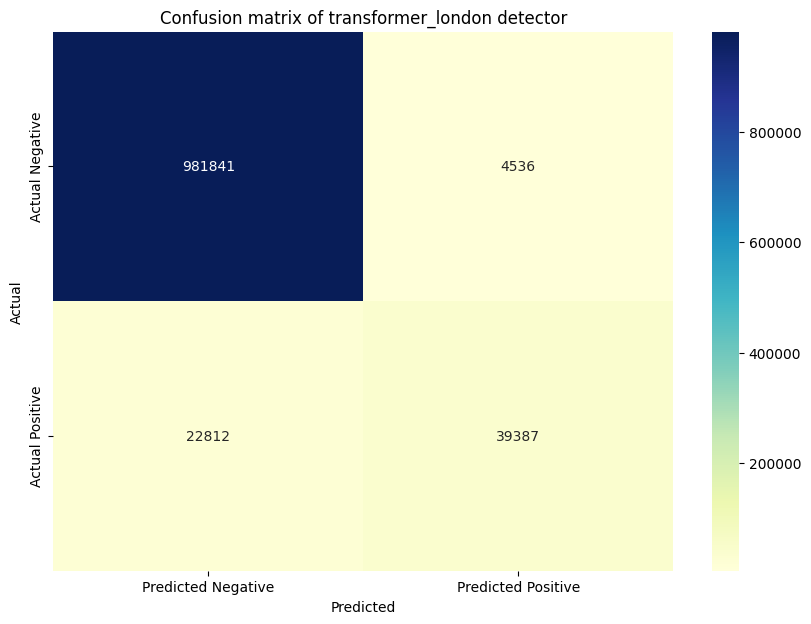

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

detector = 'transformer_london' # 'baseline', 'cnn', 'transformer'

# Construct the confusion matrix
cm = np.array([[conf_mat_values.loc[conf_mat_values.index == detector, 'tn'].iloc[0], conf_mat_values.loc[conf_mat_values.index == detector, 'fp'].iloc[0]],
               [conf_mat_values.loc[conf_mat_values.index == detector, 'fn'].iloc[0], conf_mat_values.loc[conf_mat_values.index == detector, 'tp'].iloc[0]]])
# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",  xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative','Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"Confusion matrix of {detector} detector")
plt.show()

In [16]:
for i in range(2048):
    metrics_by_sample = metrics.groupby('index')[['tn', 'fp', 'fn', 'tp']].sum()

In [17]:
best_indices = metrics_by_sample.sort_values(by=['fp', 'fn'], ascending=True).index[:3]
middle_indices = metrics_by_sample.sort_values(by=['fp', 'fn'], ascending=True).index[1023:1026]
worst_indices = metrics_by_sample.sort_values(by=['fp', 'fn'], ascending=True).index[-3:]

In [30]:
metrics_transformer = metrics.query("detector == 'transformer_noLondon'")

In [31]:
metrics_transformer.sort_values(by=["tp"], ascending=False).head(10)

,detector,accuracy,precision,recall,mse,index,tn,fp,fn,tp
1093,transformer_noLondon,0.994141,0.951613,1.000000,0.005859,364.0,450.0,3.0,0.0,59.0
385,transformer_noLondon,0.992188,0.936508,1.000000,0.007812,128.0,449.0,4.0,0.0,59.0
1039,transformer_noLondon,0.994141,0.950820,1.000000,0.005859,346.0,451.0,3.0,0.0,58.0
4249,transformer_noLondon,0.982422,0.878788,0.983051,0.017578,1416.0,445.0,8.0,1.0,58.0
1417,transformer_noLondon,0.986328,0.892308,1.000000,0.013672,472.0,447.0,7.0,0.0,58.0
2782,transformer_noLondon,0.992188,0.935484,1.000000,0.007812,927.0,450.0,4.0,0.0,58.0
4129,transformer_noLondon,0.992188,0.935484,1.000000,0.007812,1376.0,450.0,4.0,0.0,58.0
4489,transformer_noLondon,0.996094,0.966667,1.000000,0.003906,1496.0,452.0,2.0,0.0,58.0
4915,transformer_noLondon,0.998047,1.000000,0.982759,0.001953,1638.0,454.0,0.0,1.0,57.0
178,transformer_noLondon,0.996094,1.000000,0.966102,0.003906,59.0,453.0,0.0,2.0,57.0


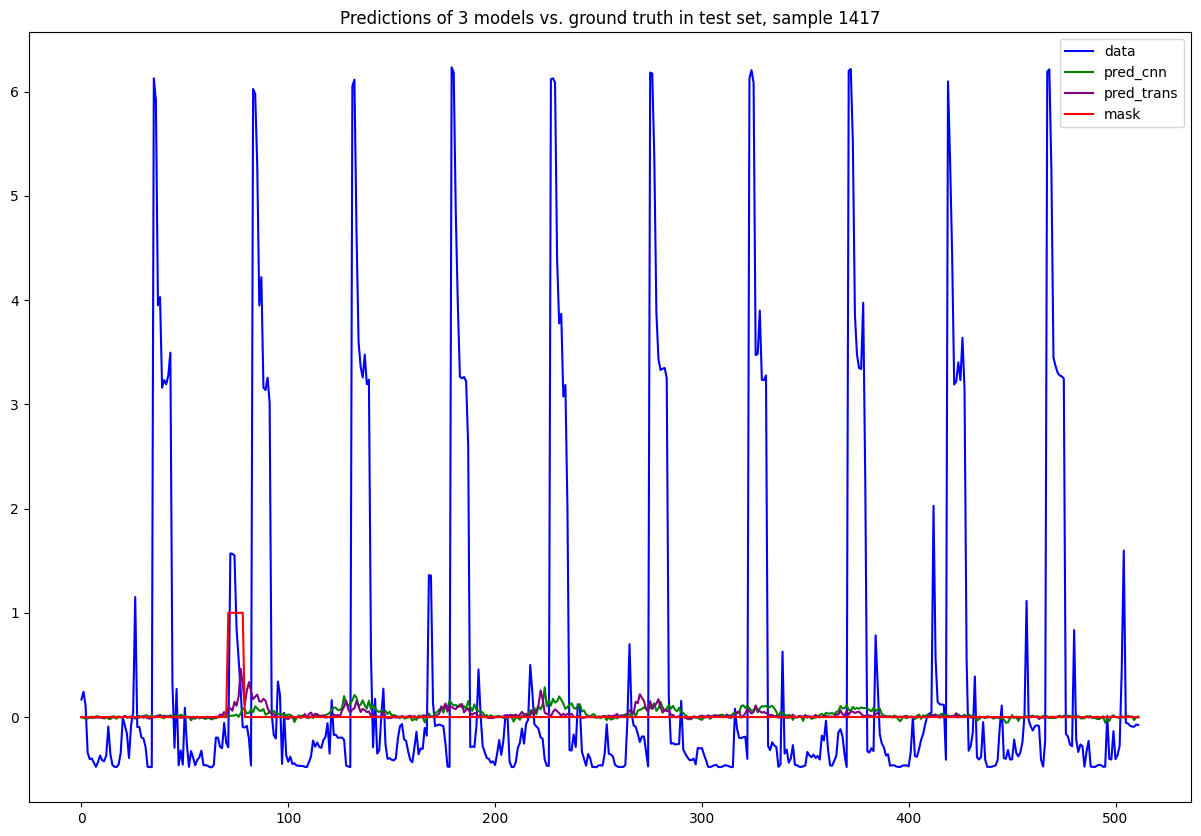

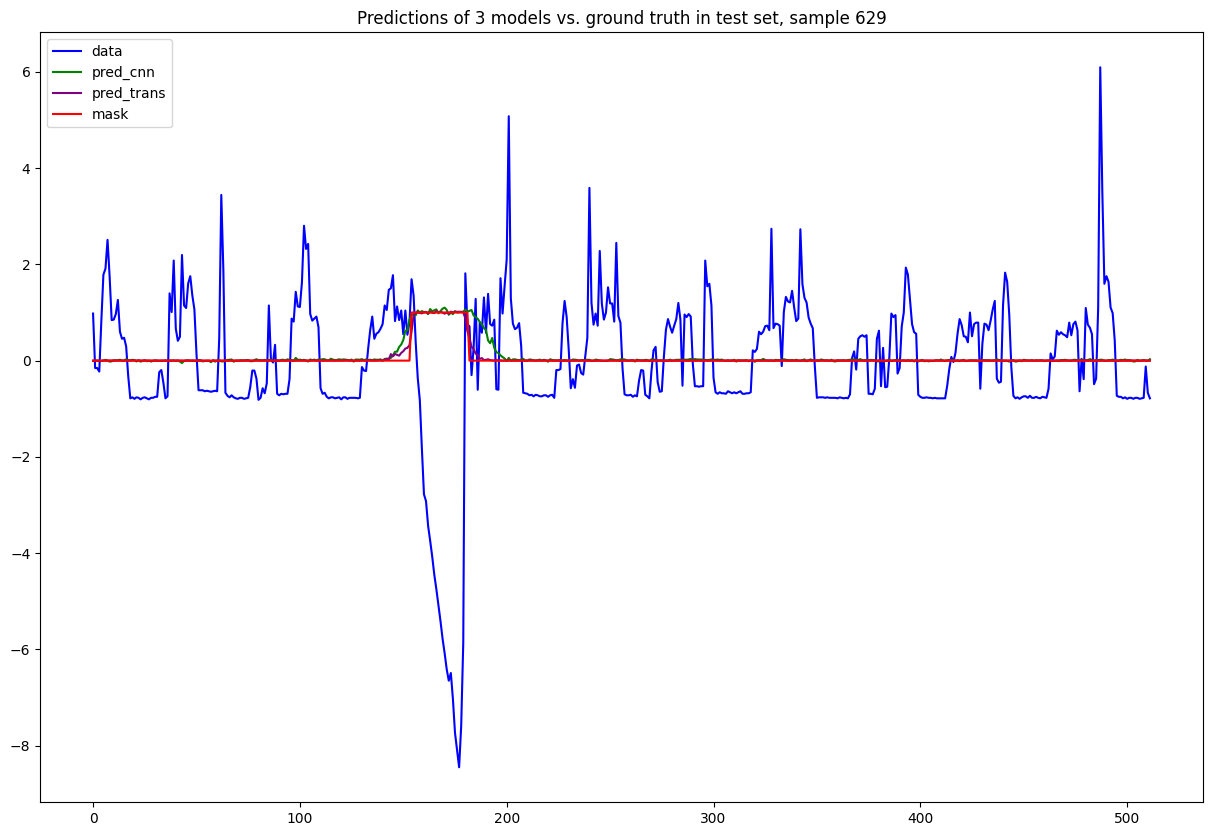

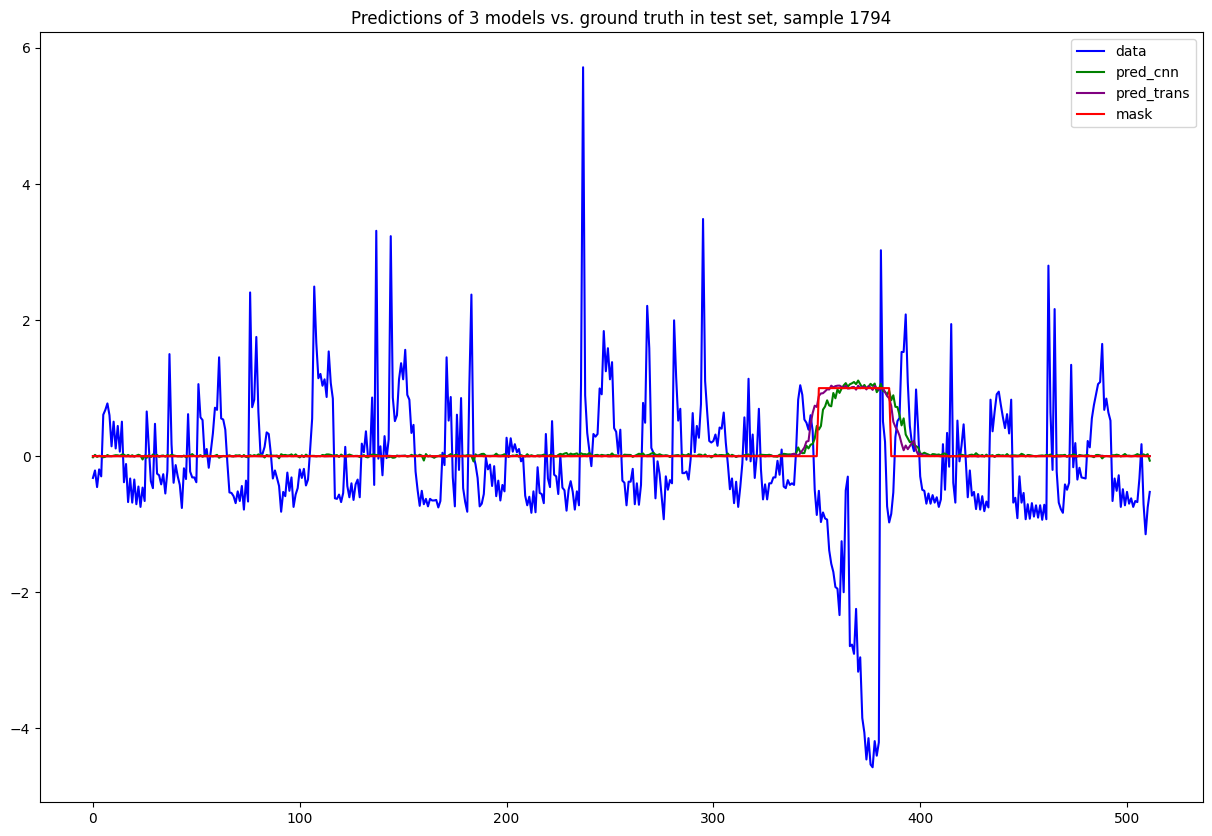

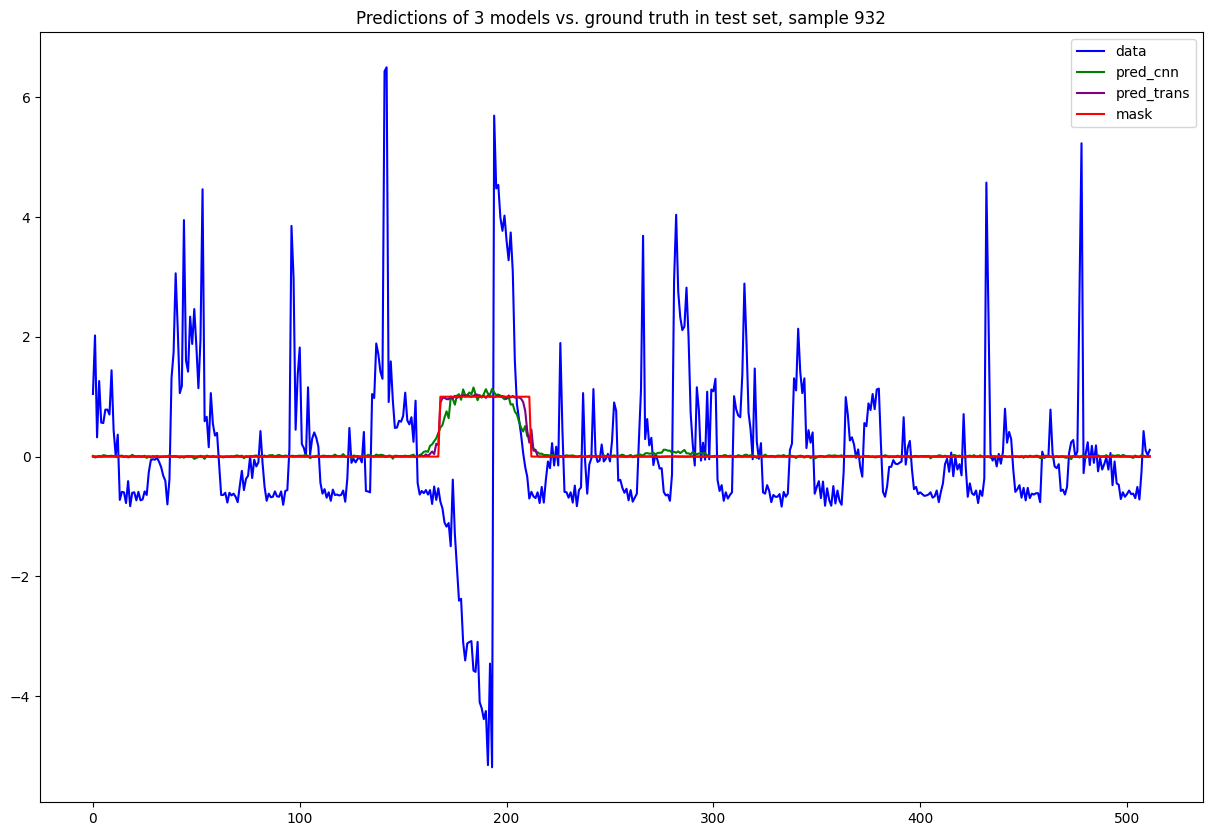

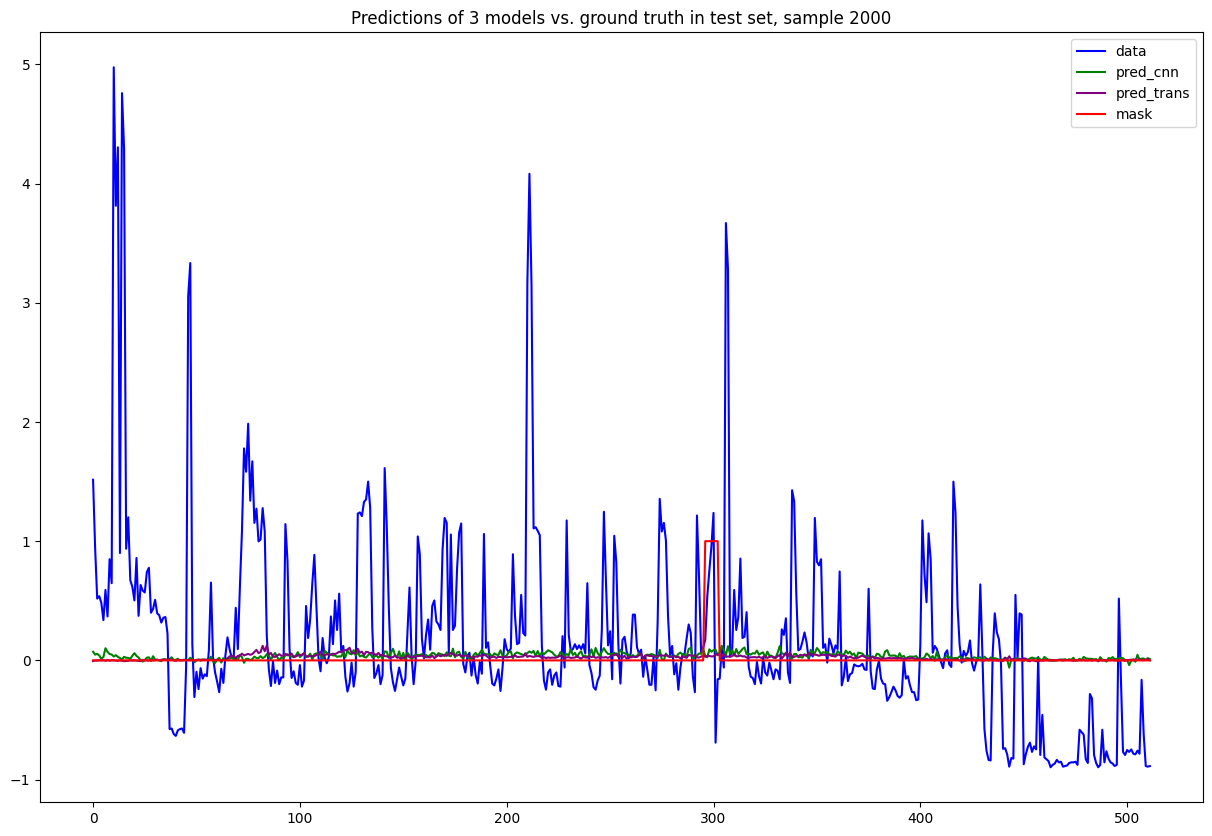

In [18]:
import matplotlib

london_fp = [1174, 800, 1813, 1228, 1926]
best_indices_tp = [1417, 629, 1794, 932, 2000]
best_indices_fp = [507, 585, 1300, 868, 26]
best_indices_fn = [1178, 725, 1554, 520, 1679] # checken

for index in best_indices_tp:
    sample = val[int(index)]
    example = sample["data"]
    stride  = 64
    window  = convolution_detector.window
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example + sample["artifact"])

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_conv = torch.zeros(((length - window) // stride + 1, length))
    predictions_trans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction
        predictions_baseline[i, j : j + window] = baseline_detector(s)
        predictions_conv[i, j : j + window] = convolution_detector(s.unsqueeze(0))
        predictions_trans[i, j : j + window] = transformer_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    predictions_baseline = predictions_baseline.sum(axis=0) / masks
    predictions_conv = predictions_conv.sum(axis=0) / masks
    predictions_trans = predictions_trans.sum(axis=0) / masks

    plt.figure(figsize=(15, 10))
    plt.plot(example_data, label="data", c="blue", linewidth=3.0)
    # plt.plot(predictions_baseline, label="pred_baseline", c="orange")
    plt.plot(predictions_conv, label="pred_cnn", c="green", linewidth=3.0)
    plt.plot(predictions_trans, label="pred_trans", c="purple", linewidth=3.0)
    plt.plot(sample["mask"], c="red", label="mask", linewidth=3.0)
    # changing the fontsize of yticks
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    matplotlib.rcParams['legend.fontsize'] = 20
    # plt.title(f"Predictions of 3 models vs. ground truth in test set, sample {int(index)}")
    plt.legend()
    plt.show()

In [45]:
stats = Path(f"../data/stats_benchmark.pkl")
stats_ds = TestArtifactDataset(file=stats)

stats_indices = [1417, 629, 1794, 932, 2000, 507, 585, 1300, 868, 26, 1178, 725, 1554, 520, 1679]

stats_benchmark = [val[index] for index in stats_indices]


In [48]:
stats_benchmark = stats_ds + stats_benchmark
len(stats_benchmark)

30

In [ ]:
pickle.dump(stats_benchmark, open('../data/stats_benchmark.pkl', "wb"))

total accuracy of transformer model 0.9896998405456543

mean mse 0.009628971

In [57]:
from sklearn.metrics import roc_curve

preds = torch.Tensor()
gt = []
for sample in val:
    stride  = 64
    window  = convolution_detector.window
    length  = len(example["data"])

    # add artifact to data
    example_data = torch.tensor(example["data"] + example["artifact"])

    # store prediction for each window
    predictions = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted

    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction
        # predictions[i, j : j + window] = detector(s.unsqueeze(0))
        predictions[i, j : j + window] = convolution_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    predictions = predictions.sum(axis=0) / masks

    preds = torch.cat((preds, predictions), dim=0)
    gt = gt + list(example["mask"])


KeyboardInterrupt: 

In [55]:
fpr_baseline, tpr_baseline, thresholds_baseline = roc_curve(gt, preds)
J_baseline = tpr_baseline - fpr_baseline
ix_baseline = np.argmax(J_baseline)
best_thresh_baseline = thresholds_baseline[ix_baseline]

In [56]:
best_thresh_baseline

0.06929581

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(example_data, label="data")
plt.plot(predictions, label="predictions")
plt.plot(example["mask"], c="red", label="mask")
plt.legend()
plt.show()